# Digital Musicology (DH-401)
## Assignment 3: Similarity
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [3]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy import signal, interpolate
pd.set_option('display.max_rows', 500)

## 0. Dataset preparation

In [4]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

# Import CSV
chorales_dataset = pd.read_csv('DM 2022 - Assignment 3 [Dataset].csv', converters = {'mn_onset': fractions.Fraction, 'act_dur': fractions.Fraction, 'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)

## Add global onset column for easy time series manipulations (in units of whole notes)
# Sort accordingly
chorales_dataset = chorales_dataset.sort_values(by=['piece', 'staff', 'mn', 'mn_onset'])
# Shift duration column by 1
chorales_dataset['_shift_dur'] = np.roll(chorales_dataset['duration'], 1)
# Get invalid first shifts that will be removed
chorales_dataset['_first_shift'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform('first')
# Cumulate shifted durations
chorales_dataset['_cum_dur_uncleaned'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform(pd.Series.cumsum)
# Subtract invalid first shifts
chorales_dataset['global_onset'] = (chorales_dataset['_cum_dur_uncleaned'] - chorales_dataset['_first_shift'])
# Remove temp coliumns
chorales_dataset = chorales_dataset.drop(columns = ['_shift_dur','_first_shift','_cum_dur_uncleaned'])

# Ignore gracenotes (there is only one)
chorales_dataset = chorales_dataset[chorales_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Remove Chorale043 because it is corrupted (it does not open in MuseScore, it does not include a closing fermata, and it has only 1 staff)
chorales_dataset = chorales_dataset[chorales_dataset['piece'] != 'BachChorales/Chorale043']

# Get unique piece/staff pairs
piece_staffs = chorales_dataset.groupby('piece')['staff'].unique().to_dict()

# Consider only until the fermata in or after the 4th bar
fermata_data = []
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        for idx, row in chorales_dataset[(chorales_dataset['piece'] == piece) & (chorales_dataset['staff'] == staff)].iterrows():
            fermata_data.append(row)
            if row['fermata'] and row['mn'] >= 4:
                break
fermata_df = pd.DataFrame(fermata_data)

# Sort by onset and staff for consistent alignment
fermata_df = fermata_df.sort_values(by=['piece', 'mn', 'mn_onset', 'staff']).reset_index(drop=True)

# Create dictionaries of last onsets, total piece durations, and smallest notes in each piece for future use
last_piece_onsets = fermata_df.groupby('piece')['global_onset'].max().apply(float).to_dict()
total_piece_durations = fermata_df.groupby(['piece','staff'])['duration'].sum().groupby('piece').max().apply(float).to_dict()
minimum_note_durations = fermata_df.groupby('piece')['duration'].min().apply(float).to_dict()

CPU times: user 20.8 s, sys: 254 ms, total: 21 s
Wall time: 21.2 s


In [5]:
# Display dataframe for random piece up to desired fermata
random_piece = fermata_df['piece'].sample(n=1).item()
random_piece_df = fermata_df[(fermata_df['piece'] == random_piece)]
random_piece_df

,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,fermata,global_onset
23367,BachChorales/Chorale324,1,0,4/4,1,1,1,1/4,1/4,1,NaN,5,71,False,0
23368,BachChorales/Chorale324,1,0,4/4,1,2,1,1/4,1/4,1,NaN,1,67,False,0
23369,BachChorales/Chorale324,1,0,4/4,1,3,1,1/4,1/4,1,NaN,4,64,False,0
23370,BachChorales/Chorale324,1,0,4/4,1,4,1,1/4,1/4,1,NaN,4,52,False,0
23371,BachChorales/Chorale324,1,1/4,4/4,1,1,1,1/4,1/4,1,NaN,5,71,False,1/4
23372,BachChorales/Chorale324,1,1/4,4/4,1,2,1,1/4,1/4,1,NaN,6,66,False,1/4
23373,BachChorales/Chorale324,1,1/4,4/4,1,3,1,1/4,1/4,1,NaN,5,59,False,1/4
23374,BachChorales/Chorale324,1,1/4,4/4,1,4,1,1/4,1/4,1,NaN,2,50,False,1/4
23375,BachChorales/Chorale324,1,1/2,4/4,1,1,1,1/4,1/4,1,NaN,3,69,False,1/2
23376,BachChorales/Chorale324,1,1/2,4/4,1,2,1,1/8,1/8,1,NaN,4,64,False,1/2


## I. Similarity parameters
### a. Rhythm

In [6]:
%%time

# Sum durations of notes in each sampling bin
summed_durations_dict = {}
# Loop
for piece in piece_staffs.keys():
    piece_df = fermata_df[fermata_df['piece'] == piece]

    last_onset = last_piece_onsets[piece]
    sampling_period = minimum_note_durations[piece]

    bins = np.arange(0, (last_onset+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_df['global_onset'], bins, right = True)
    summed_durations_dict[piece] = piece_df.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 4.96 s, sys: 60.3 ms, total: 5.02 s
Wall time: 5.17 s


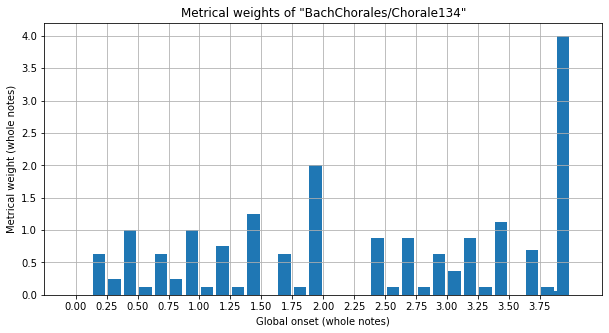

In [7]:
random_piece = fermata_df['piece'].sample(n=1).item()

last_onset = last_piece_onsets[random_piece]
sampling_period = minimum_note_durations[random_piece]
time_steps = np.arange(0, (last_onset+1e-10), sampling_period)
summed_durations = summed_durations_dict[random_piece].values

plt.figure(figsize=(10, 5))
plt.bar(time_steps, summed_durations, width=0.1)
plt.xlabel('Global onset (whole notes)')
plt.ylabel('Metrical weight (whole notes)')
plt.xticks(np.arange(0, last_piece_onsets[random_piece], 0.25))
plt.title(f'Metrical weights of "{random_piece}"')
plt.grid()
plt.show()

In [8]:
print(summed_durations_dict.items())

dict_items([('BachChorales/Chorale001', global_onset
(0.0, 0.125]     0.000
(0.125, 0.25]    1.250
(0.25, 0.375]    0.000
(0.375, 0.5]     0.625
(0.5, 0.625]     0.125
(0.625, 0.75]    1.000
(0.75, 0.875]    0.000
(0.875, 1.0]     1.375
(1.0, 1.125]     0.000
(1.125, 1.25]    0.500
(1.25, 1.375]    0.125
(1.375, 1.5]     1.000
(1.5, 1.625]     0.000
(1.625, 1.75]    0.875
(1.75, 1.875]    0.250
(1.875, 2.0]     0.500
(2.0, 2.125]     0.375
(2.125, 2.25]    1.000
(2.25, 2.375]    0.000
(2.375, 2.5]     2.000
(2.5, 2.625]     0.000
Name: duration, dtype: float64), ('BachChorales/Chorale002', global_onset
(0.0, 0.125]     0.125
(0.125, 0.25]    1.000
(0.25, 0.375]    0.000
(0.375, 0.5]     0.875
(0.5, 0.625]     0.125
(0.625, 0.75]    0.875
(0.75, 0.875]    0.125
(0.875, 1.0]     1.000
(1.0, 1.125]     0.000
(1.125, 1.25]    1.125
(1.25, 1.375]    0.000
(1.375, 1.5]     0.750
(1.5, 1.625]     0.125
(1.625, 1.75]    1.000
(1.75, 1.875]    0.000
(1.875, 2.0]     1.000
(2.0, 2.125]     0.000

In [14]:
# compute Euclidean distance between two pieces for similarity
def eucli_similarity(a,b):
    sum_similarity=0
    for i in range(len(a)):
        ab_dist=np.sqrt(np.sum(np.square(a[i]-b[i])))
        ab_similarity=1/(1+ab_dist)
        sum_similarity=sum_similarity+ab_similarity
    avg_similarity=sum_similarity/len(a)
    return avg_similarity

In [17]:
a=np.array([1,2,3,4])
b=np.array([100,0,900000,0.4])
eucli_similarity(a,b)

0.3427800553086594

### b. Melodic contour

In [9]:
%%time

# Create dictionary of frontfilled pitches for each piece and staff in each sampling bin
piece_staff_pitches_dict = {}
# Loop
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        piece_staff_df = fermata_df[(fermata_df['piece'] == piece) & (fermata_df['staff'] == staff)]

        total_duration = total_piece_durations[piece]
        sampling_period = minimum_note_durations[piece]
        
        # Create equally spaced and normalized bins sampled by minimum note resolution
        bins = np.arange(0, 1+1e-10, sampling_period/total_duration)
        binned_onsets = pd.cut(piece_staff_df['global_onset'], bins, right = False)
        # Front fill midi values as long as the onset lasts  
        piece_staff_pitches_dict[(piece,staff)] = piece_staff_df.groupby(binned_onsets)['midi'].first().ffill()

# Get mean pitches for each piece
# This is done by calculating the sum of pitches across staves and dividing by the number of staves
mean_pitches_dict = {}
for piece in piece_staffs.keys():
    cumsum = 0
    for staff in piece_staffs[piece]:
        cumsum += piece_staff_pitches_dict[(piece,staff)]
    mean_pitches_dict[piece] = cumsum / staff

# Manipulate data to get time series vs. pitches for each piece
melodic_contours = {}
for piece in piece_staffs.keys():
    time_steps = np.arange(0, 1+1e-10, minimum_note_durations[piece]/total_piece_durations[piece])
    pitches = mean_pitches_dict[piece].values
    # Front fill up to final normalized duration
    pitches = np.append(pitches, pitches[-1])
    melodic_contours[piece] = (time_steps,pitches)

CPU times: user 17.5 s, sys: 231 ms, total: 17.7 s
Wall time: 18.3 s


In [10]:
# f = interpolate.interp1d(time_steps, pitches, kind='zero')
# xnew = np.arange(0, max(time_steps), max(time_steps)/100)
# ynew = f(xnew)
# plt.figure(figsize=(10, 5))
# plt.step(time_steps/max(time_steps)*99, pitches, '--', xnew/max(time_steps)*99, ynew, '-', time_steps_r,res, '-', )
# plt.show()

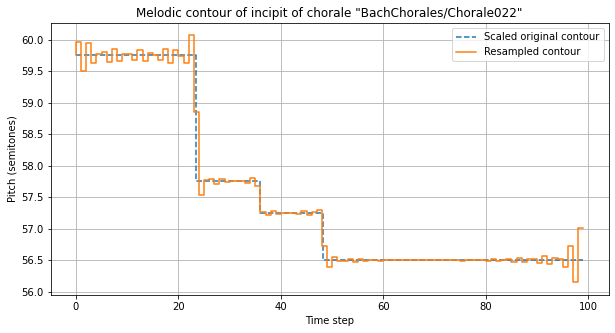

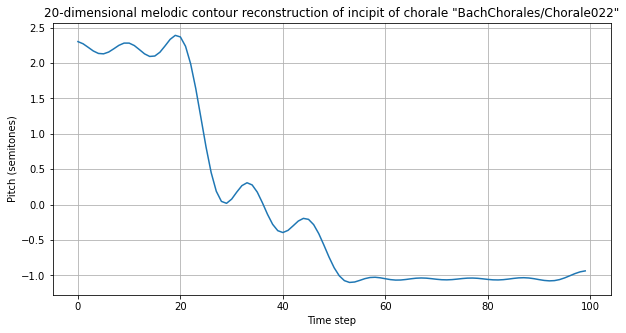

In [11]:
# Plot melodic contour of a random phrase
random_piece = fermata_df['piece'].sample(n=1).item()

time_steps = melodic_contours[random_piece][0]
pitches = melodic_contours[random_piece][1]

# Sample 100 equally spaced pitches
N = 100
time_steps_resampled = np.arange(0, N, 1)
pitches_resampled = signal.resample(pitches, num=N)

plt.figure(figsize=(10, 5))
plt.step(time_steps*(N-1), pitches, '--', time_steps_resampled, pitches_resampled, '-')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.title(f'Melodic contour of incipit of chorale "{random_piece}"')
plt.legend(['Scaled original contour', 'Resampled contour'])
plt.grid()
plt.show()

# Compute Discrete Cosine transform of signal
phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

# Discard first coefficient c0 to make contour transposition invariant
phrase_dct[0] = 0

# Reconstruct the phrase using only D dimensions
D = 20
reconstructed_phrase = idct(phrase_dct[0:D], norm='ortho', n=N)
plt.figure(figsize=(10, 5))
plt.title(f'{D}-dimensional melodic contour reconstruction of incipit of chorale "{random_piece}"')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
plt.plot(reconstructed_phrase)    

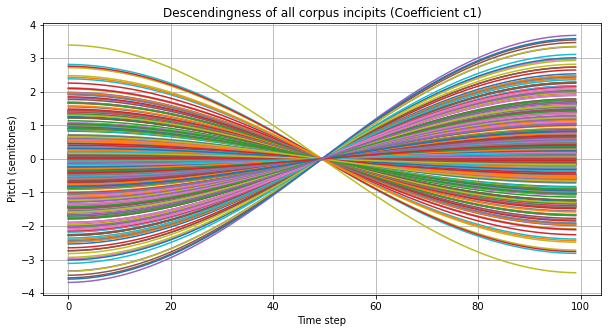

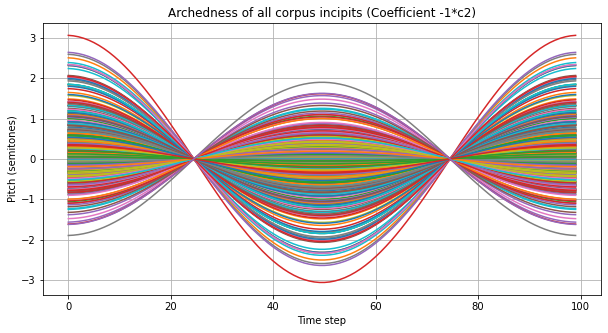

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Descendingness of all corpus incipits (Coefficient c1)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]
    
    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    desc_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    desc_dct[0] = 0

    # Plot "descendingness" c1 coefficients reconstructions for all phrases
    D = 2
    phrase_descendingness = idct(desc_dct[0:D], norm='ortho', n=N)
    plt.plot(phrase_descendingness)

plt.figure(figsize=(10, 5))
plt.title("Archedness of all corpus incipits (Coefficient -1*c2)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    time_steps_resampled = np.arange(0, 100, 1)
    pitches_resampled = signal.resample(pitches, num=100)

    # Compute Discrete Cosine transform of signal
    arch_dct = dct(pitches_resampled, norm='ortho', n=100)

    # Discard first coefficient c0 to make contour transposition invariant
    arch_dct[0] = 0    
    # Discard second coefficient c1 to only represent c2
    arch_dct[1] = 0

    # Plot "archedness" -1*c2 coefficients reconstructions for all phrases
    D = 3
    reconstructed_phrase_archedness = idct(-1*arch_dct[0:D], norm='ortho', n=100)
    plt.plot(reconstructed_phrase_archedness)